![](https://images.squarespace-cdn.com/content/v1/54ac05ebe4b0b365f77e14db/1525382987551-8BBONDY0X0G35XDX4FG7/ke17ZwdGBToddI8pDm48kDIn-TOaJZ_YZ8WW77X2puBZw-zPPgdn4jUwVcJE1ZvWEtT5uBSRWt4vQZAgTJucoTqqXjS3CfNDSuuf31e0tVG6WFl4Fnkb3hCxLccvwYe0A2OmNo2cc0iuLqoH7rPQCSb8BodarTVrzIWCp72ioWw/Spaceballs+Meme.png)

In [27]:
using Revise
using HypergraphDetectability
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack
using Plots

In [28]:
n  = 200
c₂ = 10
c₃ = 10
z  = 1 .+ (1:n .> n/2);

In [3]:
function experiment(P₂, P₃, n, c₂, c₃, z)
    P2, P3,  MI, EV = zeros(0), zeros(0), zeros(0), zeros(0)
    for p₂ ∈ P₂, p₃ ∈ P₃
        H = detectabilityData(n, c₂, c₃, p₂, p₃);
        BP_mat, ix = linearizedBPMatrix(H, z; reduced = true);
        try 
            E = Arpack.eigs(BP_mat; nev = 2, ritzvec = true)
            
            for ev ∈ 1:2
                u = E[2][:,ev][(n+1):2n]
                if !(mean(abs.(imag.(u))) ≈ 0)
                    mi = 0.0
                    append!(P2, p₂)
                    append!(P3, p₃)
                    append!(MI, mi)
                    append!(EV, ev)
                else
                    clusters = 1 .+ (real.(u) .> 0)
                    mi = mutualinfo(clusters, z)
                    append!(P2, p₂)
                    append!(P3, p₃)
                    append!(MI, mi)
                    append!(EV, ev)
                end
            end
        catch e
            nothing
        end
    end
    DF = DataFrame(
        P_2 = P2, 
        P_3 = P3, 
        MI = MI, 
        EV = EV
    )
    return DF
end

experiment (generic function with 1 method)

**Note**: the below cell takes quite a while to run!! Dropping the resolution of the grid or the number of repetitions is encouraged. 

In [ ]:
n_reps = 20
DF = DataFrame()

for rep ∈ 1:n_reps
    println("round $(rep)")
    df = experiment(0:0.02:1, 0:0.02:1, n, c₂, c₃, z);
    append!(DF, df)
end

The following block can be used for caching the results of the above computation for easy subsequent access. 

In [21]:
R"""
library(tidyverse)
df <- tibble($(DF))
df
# df %>% write_csv("throughput/linearized-bp-heatmap-reduced.csv")
""";

## Visualizations

Now we're ready to visualize the results. First, we'll separately plot the recovery results when using the first and second eigenvectors separately. 

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   P_2 = col_double(),
│   P_3 = col_double(),
│   MI = col_double(),
│   EV = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


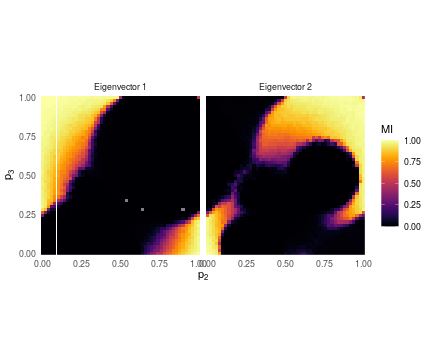

RObject{VecSxp}


In [22]:
R"""
library(tidyverse)
library(viridis)

df <- read_csv("throughput/linearized-bp-heatmap-reduced.csv")

df <- df %>%
    group_by(P_2, P_3, EV) %>% 
    summarise(MI = mean(MI, na.rm = T)) %>% 
    mutate(EV = paste0("Eigenvector ", EV))

p <- df %>% 
    ggplot() + 
    aes(x = P_2, y = P_3, fill = MI) + 
    geom_tile() + 
    theme_minimal() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1)) + 
    scale_x_continuous(expand = c(0,0)) + 
    scale_y_continuous(expand = c(0,0)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(panel.grid = element_blank()) + 
    coord_fixed() + 
    facet_wrap(~EV)

ggsave("fig/linearized-bp-heatmap-2-panel-reduced.png", p,  width = 7, height = 3)
p
"""


We can make an attractive combined plot in which the color of the tile corresponds to the eigenvector used to construct it. Paler tiles correspond to partial or failed recoveries, pink tiles correspond to recovery from the first eigenvector, and blue tiles to recoveries from the second eigenvector. 

There are labelling issues; due to the way I constructed this particular plot, it is difficult to get a professional legend giving a scale for the color shade intensity. Work in progress. 

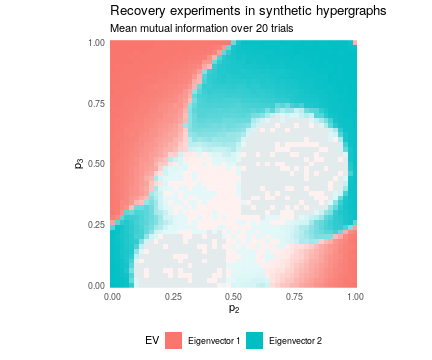

RObject{VecSxp}


In [23]:
R"""
p <- df %>% 
    group_by(P_2, P_3) %>% 
    filter(MI == max(MI)) %>% 
    mutate(MI = MI * (-1)^(EV == "Eigenvector 1")) %>% 
    mutate(f = MI > 0) %>% 
    ggplot() + 
    aes(x = P_2, y = P_3, fill = EV, alpha = abs(MI)) + 
    geom_tile() + 
    theme_minimal() + 
    scale_x_continuous(expand = c(0,0)) + 
    scale_y_continuous(expand = c(0,0)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(panel.grid = element_blank()) + 
    coord_fixed() + 
    guides(alpha = FALSE) + 
    theme(legend.position = "bottom") + 
    ggtitle("Recovery experiments in synthetic hypergraphs", 
            subtitle = "Mean mutual information over 20 trials")

ggsave("fig/linearized-bp-heatmap-reduced.png", p,  width = 4, height = 4)
p
"""

In [24]:
R"""

C = $(c₂)
D = $(c₃)

curve <- tibble(P_2 = seq(0, 1, 0.00001)) %>% 
    mutate(l_2 = 2*P_2 - 1,
           P_3 = (1 + 3*sqrt((1 - l_2^2*C)/(2*D)))/4,
           Q_3 = (1 - 3*sqrt((1 - l_2^2*C)/(2*D)))/4)

""";

┌ Warning: RCall.jl: Warning in sqrt((1 - l_2^2 * C)/(2 * D)) : NaNs produced
│ Warning in sqrt((1 - l_2^2 * C)/(2 * D)) : NaNs produced
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


┌ Warning: RCall.jl: Warning: Removed 55280 row(s) containing missing values (geom_path).
│ Warning: Removed 55280 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


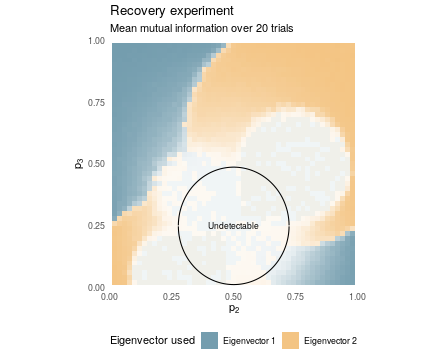

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 55280 row(s) containing missing values (geom_path).
│ Warning: Removed 55280 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [25]:
R"""
inauguration_2021 <- c("#5445b1", "#749dae", "#f3c483", "#5c1a33", "#cd3341","#f7dc6a")
p <- df %>% 
    group_by(P_2, P_3) %>% 
    filter(MI == max(MI)) %>% 
    mutate(MI = MI * (-1)^(EV == "Eigenvector 1")) %>% 
    mutate(f = MI > 0) %>% 
    ggplot() + 
    geom_tile(aes(x = P_2, y = P_3, fill = EV, alpha = abs(MI))) + 
    theme_minimal() + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 1)) + 
    scale_y_continuous(expand = c(0,0), limits = c(0, 1)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(panel.grid = element_blank()) + 
    coord_fixed() + 
    guides(alpha = FALSE, fill = guide_legend(title = "Eigenvector used")) + 
    theme(legend.position = "bottom") + 
    ggtitle("Recovery experiment", 
            subtitle = "Mean mutual information over 20 trials") + 
    geom_line(aes(x = P_2, y = P_3), data = curve) + 
    geom_line(aes(x = P_2, y = Q_3), data = curve) + 
    scale_fill_manual(values = inauguration_2021[2:3]) + 
    annotate("text", x = 0.5, y = 0.25, label = "Undetectable", size = 3)

ggsave("fig/linearized-bp-heatmap-with-annotation-reduced.png", p,  width = 6, height = 5)
p
"""

┌ Warning: RCall.jl: Warning in sqrt((1 - l_2^2 * C)/(2 * D)) : NaNs produced
│ Warning in sqrt((1 - l_2^2 * C)/(2 * D)) : NaNs produced
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Warning: Removed 55280 row(s) containing missing values (geom_path).
│ Warning: Removed 55280 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


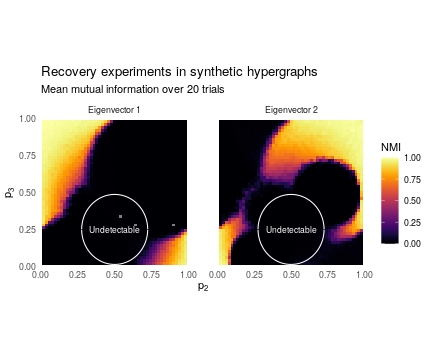

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 55280 row(s) containing missing values (geom_path).
│ Warning: Removed 55280 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [26]:
R"""
inauguration_2021 <- c("#5445b1", "#749dae", "#f3c483", "#5c1a33", "#cd3341","#f7dc6a")

C = $(c₂)
D = $(c₃)

curve <- tibble(expand.grid(P_2 = seq(0, 1, 0.00001), EV = c("Eigenvector 1", "Eigenvector 2"))) %>% 
    mutate(l_2 = 2*P_2 - 1,
           P_3 = (1 + 3*sqrt((1 - l_2^2*C)/(2*D)))/4,
           Q_3 = (1 - 3*sqrt((1 - l_2^2*C)/(2*D)))/4)


p <- df %>% 
    ggplot() + 
    geom_tile(aes(x = P_2, y = P_3, fill = MI)) + 
    theme_minimal() + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 1)) + 
    scale_y_continuous(expand = c(0,0), limits = c(0, 1)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(panel.grid = element_blank(), panel.spacing = unit(2, "lines")) + 
    coord_fixed() + 
    facet_wrap(~EV) + 
    guides(alpha = FALSE, fill = guide_colorbar(title = "NMI")) + 
    ggtitle("Recovery experiments in synthetic hypergraphs", 
            subtitle = "Mean mutual information over 20 trials") + 
    geom_line(aes(x = P_2, y = P_3), data = curve, color = "white") + 
    geom_line(aes(x = P_2, y = Q_3), data = curve, color = "white") + 
    annotate("text", x = 0.5, y = 0.25, label = "Undetectable", color = "white", size = 3) + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1))

ggsave("fig/linearized-bp-heatmap-with-annotation-reduced-2-panel.png", p,  width = 8, height = 4)
p
"""

# What's with the nonconvex undetectable region?

I would have kind of imagined that the undetectable region would be convex, and it appears that this is theoretically correct. When working with the *unreduced* nonbacktracking matrices, the undetectable region indeed appears to be convex, while when working with the *reduced* nonbacktracking matrices this appears not to be the case. Presumably this is due either to an alignment issue with the eigenvectors or a gap in the interpretation of the reduced matrix when thinking about belief-propagation. 

Here's a hypergraph in what appears to be the undetectable regime for the reduced version, but is detectable for the unreduced version. 

In [11]:
n  = 500
c₂ = 5
c₃ = 5
z  = 1 .+ (1:n .> n/2);
p₂ = 0.6
p₃ = 0.6
H = detectabilityData(n, c₂, c₃, p₂, p₃);

In [12]:

BP_mat, ix = linearizedBPMatrix(H, z; reduced = true);

UndefVarError: UndefVarError: counts not defined

In [13]:
E = Arpack.eigs(BP_mat; nev = 2, ritzvec = true);

UndefVarError: UndefVarError: BP_mat not defined

In [14]:
E[1]

UndefVarError: UndefVarError: E not defined

Complex second eigenvalue -- no go. 

In [15]:
H = detectabilityData(n, c₂, c₃, p₂, p₃);
BP_mat, ix = linearizedBPMatrix(H, z; reduced = false);
E = Arpack.eigs(BP_mat; nev = 2, ritzvec = true);

UndefVarError: UndefVarError: counts not defined

In [16]:
E[1]

UndefVarError: UndefVarError: E not defined

Real second eigenvalue -- detectable!! 

Why is this? 

In [17]:
Bs = reducedNonBacktrackingMatrices(H)

E = Arpack.eigs(Bs[2]; nev = 2, ritzvec = true);
E[1]

Arpack.ARPACKException: ARPACKException: unspecified ARPACK error: 1

In [18]:
Bs, ix = nonBacktrackingMatrices(H)

E = Arpack.eigs(Bs[2]; nev = 2, ritzvec = true);
E[1]

Arpack.ARPACKException: ARPACKException: unspecified ARPACK error: 1